In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#unzip the dataset folder
!unzip /content/drive/MyDrive/thesisproject/data.csv.zip

Archive:  /content/drive/MyDrive/thesisproject/data.csv.zip
  inflating: data.csv                


# 1. Overview and understanding of data

## Install libraries

In [2]:
!pip install squarify

## Load libraries

In [3]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.express as px

from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from matplotlib.ticker import PercentFormatter
%matplotlib inline

pd.set_option("display.max_rows", None,"display.max_columns", None)

warnings.simplefilter(action='ignore')
plt.style.use('seaborn')
sns.set_style("darkgrid")

## reading the dataset

In [4]:
# Importing data.csv
df = pd.read_csv('/content/data.csv', sep=",", encoding="unicode_escape", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## understanding the dataset

In [5]:
# basics of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
print("We have {} observations.".format(df.shape[0]))

df.dropna(inplace=True)

print("We have {} observations after removing null values.".format(df.shape[0]))

We have 541909 observations.
We have 406829 observations after removing null values.


We are done with systematically missing values. But lets go deeper.

Sometimes, missing values are filled with some denotations. "NAN", "na", "?", "Unknown", and so on. Let's check them.

In [8]:
df[df.Description.str.len() < 5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Nothing!

Lets check invoiceNo!

In [9]:
df.InvoiceNo.value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
567656     421
567183     399
575607     377
571441     364
570488     353
572552     352
568346     335
547063     294
569246     285
562031     277
554098     264
543040     259
570672     259
569897     239
572103     223
562046     219
566290     217
578233     212
574328     208
556484     205
571653     202
577504     198
579470     194
574481     191
575491     189
561894     188
578041     184
580956     184
581405     183
569866     182
565150     179
560504     178
572913     178
552039     176
540372     171
563613     171
537224     169
562688     168
563557     166
545901     164
579167     164
569220     163
537781     161
574700     160
560209     158
571883     158
579516     158
540247     157
573300     157
548714     157
573904     156
547358     155
572703     154
577057     154
564342     153
574714     151
565541     150
572309     150
540458     149
568712     148
578921     148
575602    

InvoiceNo has coded with 6 digit numeric characters. We can see that some InvoiceNo records starts with the letter C. This means cancellation.

In [10]:
df[df["InvoiceNo"].str.startswith("C")].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


Cancelled invoices have negative quantity.

In [11]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

In [12]:
df = df[df.Cancelled == 0]
df.shape

(397924, 9)

Stock Codes generally contains 5 digit numerical codes.



In [13]:
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [14]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

It looks like data contains more than customer transactions. I will drop them.

In [15]:
df[df.StockCode.str.len() > 5].StockCode.value_counts()

85123A          2035
85099B          1618
82494L           820
85099F           664
85099C           659
84997D           429
84970S           415
47591D           401
15056N           382
84596B           379
47590B           363
47590A           356
85049E           347
84970L           338
84997B           330
84029E           328
84029G           326
47566B           317
84997C           309
85014B           306
84596F           304
15056BL          291
84030E           287
85049A           274
85014A           257
16161P           249
47559B           246
84406B           244
85049G           244
84997A           234
84536A           225
85049C           212
46000S           182
47504K           179
48173C           176
85199S           170
47503A           168
16156S           167
84596G           162
51014A           161
72351B           159
84510A           151
16169E           150
35471D           148
47599A           146
85034C           142
85184C           140
84509A       

In [16]:
df[df.StockCode.str.len() > 5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
HANGING HEART ZINC T-LIGHT HOLDER       415
PINK FAIRY CAKE CHILDRENS APRON         401
EDWARDIAN PARASOL NATURAL               382
SMALL DOLLY MIX DESIGN ORANGE BOWL      379
PINK HAPPY BIRTHDAY BUNTING             363
BLUE HAPPY BIRTHDAY BUNTING             356
SCANDINAVIAN REDS RIBBONS               347
SINGLE HEART ZINC T-LIGHT HOLDER        338
RED WOOLLY HOTTIE WHITE HEART.          328
CHILDRENS CUTLERY POLKADOT PINK         328
KNITTED UNION FLAG HOT WATER BOTTLE     326
TEA TIME PARTY BUNTING                  317
RED RETROSPOT UMBRELLA                  306
SMALL MARSHMALLOWS PINK BOWL            304
EDWARDIAN PARASOL BLACK                 291
ENGLISH ROSE HOT WATER BOTTLE           287
TRADITIONAL CHRISTMAS RIBBONS           274
BLACK/BLUE POLKADOT UMBRELLA    

Some stock codes have a letter at the end of their codes. I don't know what they refers, so I will keep them.

In [17]:
df =  df[~ df.StockCode.str.contains("^[a-zA-Z]")]
df.shape

(396370, 9)

In [18]:
df["Description"] = df["Description"].str.lower()

I just standardize descriptions with converting them to all lowercase characters.

Stock Codes - Description

In [19]:
df.groupby("StockCode")["Description"].nunique()[df.groupby("StockCode")["Description"].nunique() != 1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
21109     2
21112     2
21175     2
21232     2
21243     2
21507     2
21811     2
21818     2
21899     2
21928     2
22129     2
22134     2
22135     2
22179     2
22197     2
22199     2
22246     2
22268     2
22285     2
22286     2
22287     2
22383     2
22407     2
22416     2
22466     2
22502     2
22584     2
22595     2
22597     2
22602     2
22632     2
22776     3
22777     2
22778     2
22785     2
22804     2
22812     2
22813     2
22837     2
22847     2
22849     2
22896     2
22900     2
22932     2
22937     3
22939     2
22949     2
22950     2
22952     2
22953     2
22963     2
22965     2
22972     2
22985     2
22986     2
22999     2
23015     2
23020     2
23028     2
23029     2
23031     2
23032     2
23035     2
23040     2
23041     2
23043     2
23044     2
23045     2
23047     2
23056     2
23057     2
23061     2
23065     2
23066     2
23068     2
23071     2
23075     2
23079 

Some Stock codes have more than one description. Let's check some of them.



In [20]:
df[df.StockCode == "16156L"].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [21]:
df[df.StockCode == "17107D"].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

Seems we have just a litle differences between them, i.e. "," or "/"

In [22]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
15311.0    2379
14646.0    2064
13089.0    1818
13263.0    1672
14298.0    1637
15039.0    1502
14156.0    1387
18118.0    1278
14159.0    1203
14796.0    1140
16033.0    1137
15005.0    1118
14056.0    1106
14769.0    1089
13081.0    1028
16549.0     981
14527.0     971
14456.0     968
17511.0     963
15719.0     936
16931.0     898
15555.0     897
17811.0     850
14505.0     799
18283.0     754
17338.0     751
17757.0     740
12921.0     720
12415.0     715
15159.0     710
16904.0     708
16764.0     706
17675.0     705
13137.0     704
15547.0     702
17920.0     695
17735.0     690
16923.0     672
15529.0     671
16241.0     662
16360.0     662
16729.0     659
15856.0     644
13969.0     626
16713.0     624
14502.0     623
12681.0     616
13230.0     611
14415.0     590
14088.0     589
16686.0     585
14194.0     579
17611.0     576
14667.0     572
13098.0     572
13694.0     568
17238.0     566
17602.0 

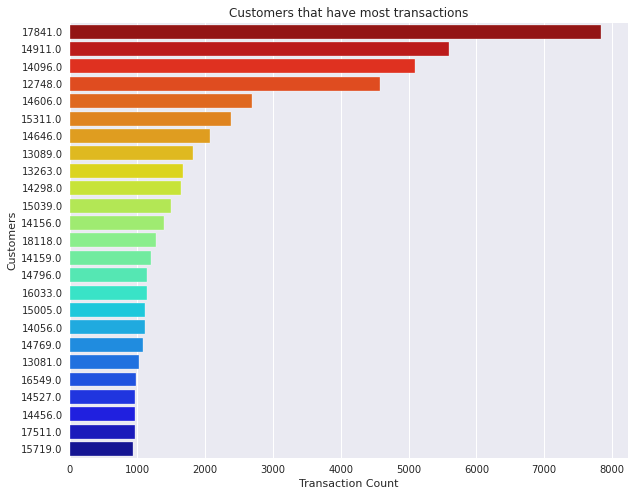

In [23]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "jet_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

In [24]:
df.Country.value_counts()

United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
RSA                         57
European Community          57
Lebanon                     45
Lithuani

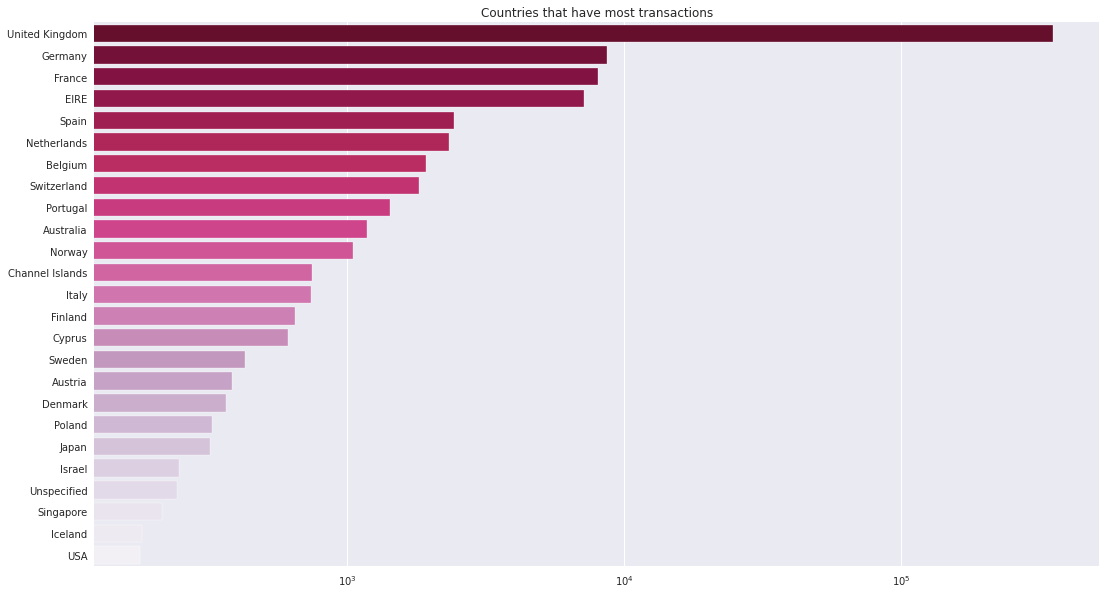

In [25]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "PuRd_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [26]:
df["UnitPrice"].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

0 unit price?



In [27]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


## Data cleaning

I didn't find any pattern. So, I remove them.

In [28]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.UnitPrice > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 396370 observations.
We have 396337 observations after removing records that have 0 unit price.


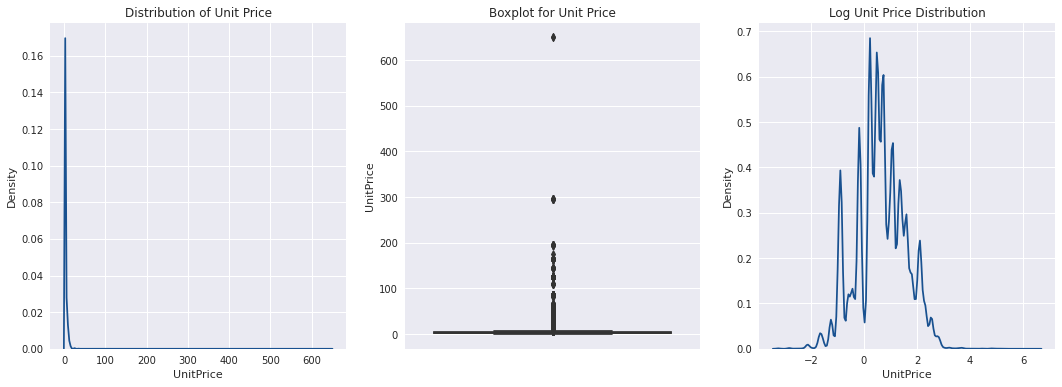

In [29]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [30]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [31]:
np.quantile(df.UnitPrice, 0.99)

12.75

In [32]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.UnitPrice > 0.1) & (df.UnitPrice < 20)]

print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20.".format(df.shape[0]))

We have 396337 observations.
We have 395385 observations after removing unit prices smaller than 0.1 and greater than 20.


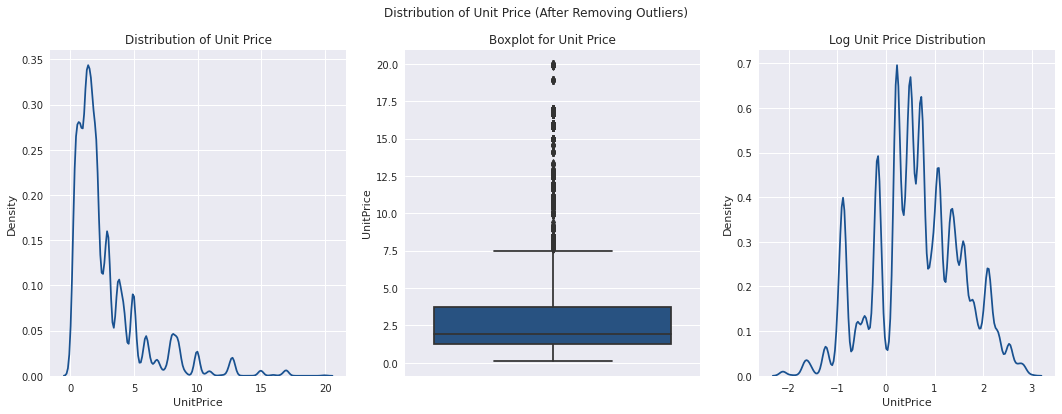

In [33]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [34]:
df["Quantity"].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [35]:
np.quantile(df.Quantity, 0.99)

120.0

In [36]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 395385 observations.
We have 392735 observations after removing quantities greater than 150.


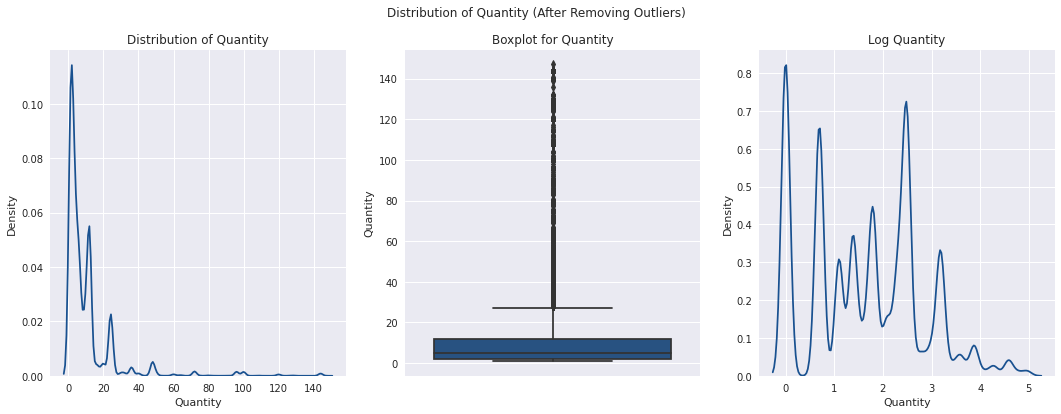

In [37]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

## making additional columns

In [38]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate2'] = df['InvoiceDate']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate2'].head(5)

0    12/1/2010 8:26
1    12/1/2010 8:26
2    12/1/2010 8:26
3    12/1/2010 8:26
4    12/1/2010 8:26
Name: InvoiceDate2, dtype: object

In [39]:
df.drop("Cancelled", axis = 1, inplace = True)
df.to_csv("/content/drive/MyDrive/thesisproject/online_retail_final.csv", index = False)

## saving modified dataset

In [40]:
!cp "/content/drive/MyDrive/thesisproject/online_retail_final.csv" newData.csv

# 2. Cohort Analysis

A cohort simply means that a group of people they have same characteristics.

Generally, we have three type of cohort analysis:

* Time cohorts or Acquisition cohorts: Groups are divided by first activity.
* Behavior cohorts or Segment-Based cohorts: Groups are divided by their behaivors and actions about your service.
* Size cohorts: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.

Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.

Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.

Cohort analysis proves to be valuable because it helps to separate growth metrics from engagement metrics as growth can easily mask engagement problems. In reality, the lack of activity of the old users is being hidden by the impressive growth numbers of new users, which results in concealing the lack of engagement from a small number of people.

*https://clevertap.com/blog/cohort-analysis/

Cohort analysis is a better way of looking at data. Its application is not limited to a single industry or function. For example, eCommerce companies can use cohort analysis to spot products that have more potential for sales growth. In digital marketing, it can help identify web pages that perform well based on time spent on websites, conversions or sign-ups. In product marketing, this analysis can be used to identify the success of feature adoption rate and also to reduce churn rates.

*https://www.moengage.com/blog/growth-tactic-1-how-to-use-cohort-analysis-to-measure-customer-retention/

In [41]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("Time difference is: {}".format(df.InvoiceDate.max() - df.InvoiceDate.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


In [42]:
import datetime as dt

In [43]:
def get_month(x): return dt.datetime(x.year, x.month, 1) 
def get_dates(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [44]:
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")

In [45]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDate2,InvoiceMonth,CohortMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12/1/2010 8:26,2010-12-01,2010-12-01
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12/1/2010 8:26,2010-12-01,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01


In [46]:
invoice_year, invoice_month, invoice_day = get_dates(df, "InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = 12 * year_diff + month_diff + 1

In [47]:
cohort_data = df.groupby(["CohortIndex", "CohortMonth"])["CustomerID"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "CustomerID")

cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,874.0,319.0,280.0,329.0,317.0,350.0,316.0,303.0,304.0,345.0,327.0,440.0,231.0
2011-01-01,409.0,91.0,112.0,94.0,131.0,119.0,103.0,100.0,123.0,135.0,151.0,48.0,NaN
2011-02-01,375.0,68.0,69.0,103.0,100.0,90.0,94.0,100.0,92.0,115.0,25.0,NaN,NaN
2011-03-01,450.0,66.0,111.0,90.0,101.0,75.0,119.0,104.0,124.0,38.0,NaN,NaN,NaN
2011-04-01,297.0,64.0,61.0,61.0,56.0,68.0,65.0,77.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,280.0,55.0,48.0,49.0,59.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,240.0,42.0,38.0,64.0,54.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,189.0,34.0,39.0,42.0,50.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,170.0,32.0,41.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above data is our cohort table. Its interpretation is simple. For example, We have 874 unique customer with their first transaction is in 2010-12. Its cohort month is 2010-12 and cohort index is 1. Go on the one right cell, it is 319. Its mean, 319 unique customer retain their customership for next month.

## Retention Rate

Retention tables show a group of people that visited your site or used your app for the first time during a certain time frame. They also display the progressive ‘drop-off’ or decline in activity over time for that particular group (a cohort).

Marketers can use Retention tables to analyze the quality of users brought by a marketing campaign and compare it to other sources of traffic.

In [48]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.364989,0.320366,0.376430,0.362700,0.400458,0.361556,0.346682,0.347826,0.394737,0.374142,0.503432,0.264302
2011-01,1.0,0.222494,0.273839,0.229829,0.320293,0.290954,0.251834,0.244499,0.300733,0.330073,0.369193,0.117359,NaN
2011-02,1.0,0.181333,0.184000,0.274667,0.266667,0.240000,0.250667,0.266667,0.245333,0.306667,0.066667,NaN,NaN
2011-03,1.0,0.146667,0.246667,0.200000,0.224444,0.166667,0.264444,0.231111,0.275556,0.084444,NaN,NaN,NaN
2011-04,1.0,0.215488,0.205387,0.205387,0.188552,0.228956,0.218855,0.259259,0.074074,NaN,NaN,NaN,NaN
2011-05,1.0,0.196429,0.171429,0.175000,0.210714,0.232143,0.267857,0.092857,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.175000,0.158333,0.266667,0.225000,0.325000,0.095833,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.179894,0.206349,0.222222,0.264550,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.188235,0.241176,0.241176,0.129412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


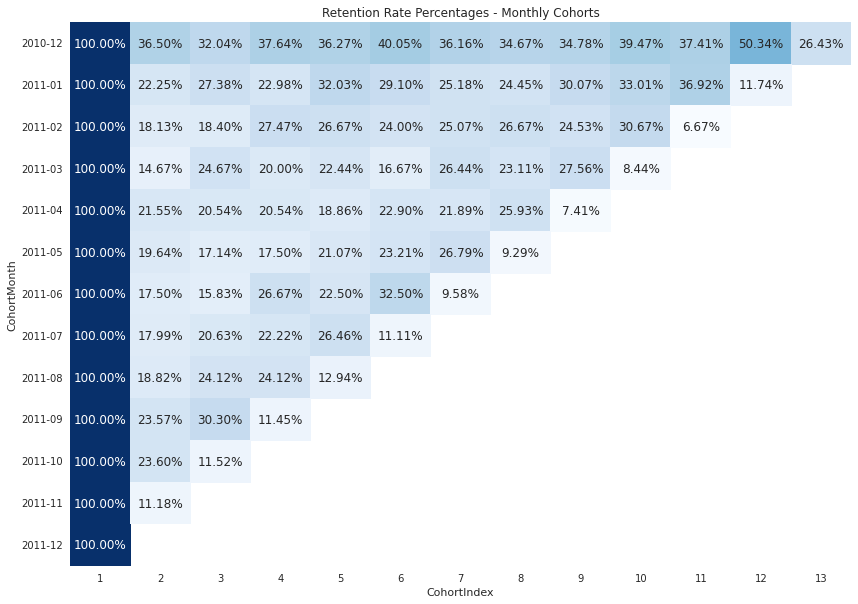

In [49]:
plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

Let's look at above retention rate chart and interpret it.

40.05% of customers that made their first shopping in January 2011, use this company after five months.

In [50]:
customer_per_month = df.groupby("CohortMonth")["CustomerID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4298, 4259, 3937, 3581, 3284, 3114, 2925, 2685, 2405, 2108, 1658,
       1283,  874])

In [51]:
customer_in_month = df.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month

CohortIndex
1     4298
2      961
3      930
4      907
5      890
6      866
7      795
8      710
9      665
10     633
11     503
12     488
13     231
Name: CustomerID, dtype: int64

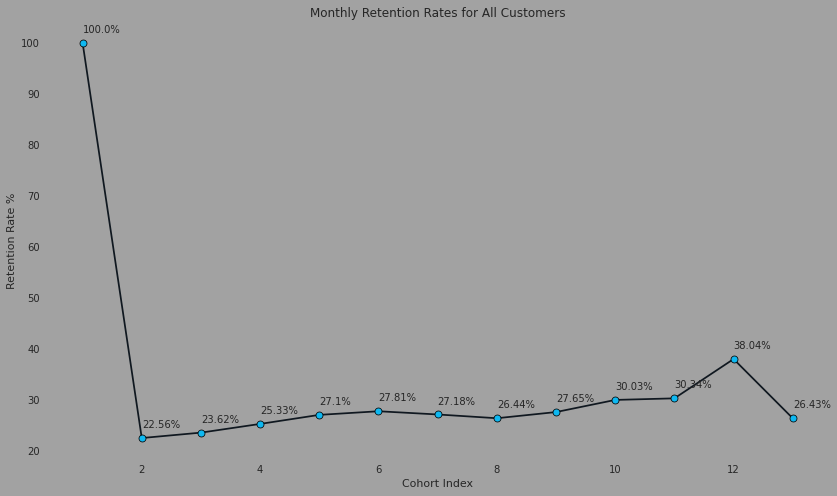

In [52]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")

plt.xlabel("Cohort Index")
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers")
sns.despine()
plt.show()

Great!

Retention rate increases significantly for last months of the year.

Probably, Thanksgiving, Black Friday and Christmas causes it. There are lots of special day at the end of year.

In [53]:
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})

monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,477001.27,874
2011-01-01,402460.88,728
2011-02-01,384935.12,746
2011-03-01,501435.63,959
2011-04-01,389147.37,843
2011-05-01,578653.77,1039
2011-06-01,502033.11,981
2011-07-01,495787.75,937
2011-08-01,512410.08,920


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


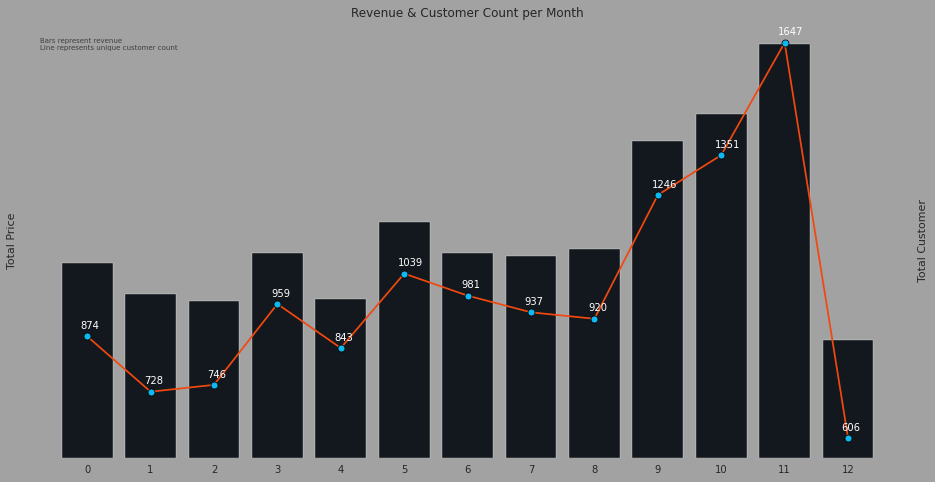

In [54]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

## Pareto Principle

*  The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).

Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.
* Lets implement Pareto's 80-20 rule to our dataset. We have two hypothesis:
    - 1) 80% of company's revenue comes from 20% of total customers.

    - 2) 80% of company's revenue comes from 20% of total products.

To check these hypothesis, we need only two things.

- 1) Individual sale records for customer/product

- 2) Calculating cumulative sum for them

I define below functions for calculation and visualization.

* prepare_pareto_data finds individual revenue per customer/product and calculates cumulative percentage of them.

* create_pareto_plot takes output from these data and visualize it.

In [55]:
def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["CumulativePercentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

In [56]:
def create_pareto_plot(df, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

### Pareto Chart for Customers

In [57]:
customer_price = prepare_pareto_data(df, "CustomerID", "TotalPrice")

customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,189796.00,2.65
14911.0,129795.43,4.46
12415.0,81455.09,5.60
14156.0,81329.92,6.73
18102.0,80619.70,7.86
17511.0,78595.72,8.95
15311.0,57178.46,9.75
13089.0,56618.82,10.54
14096.0,52147.65,11.27


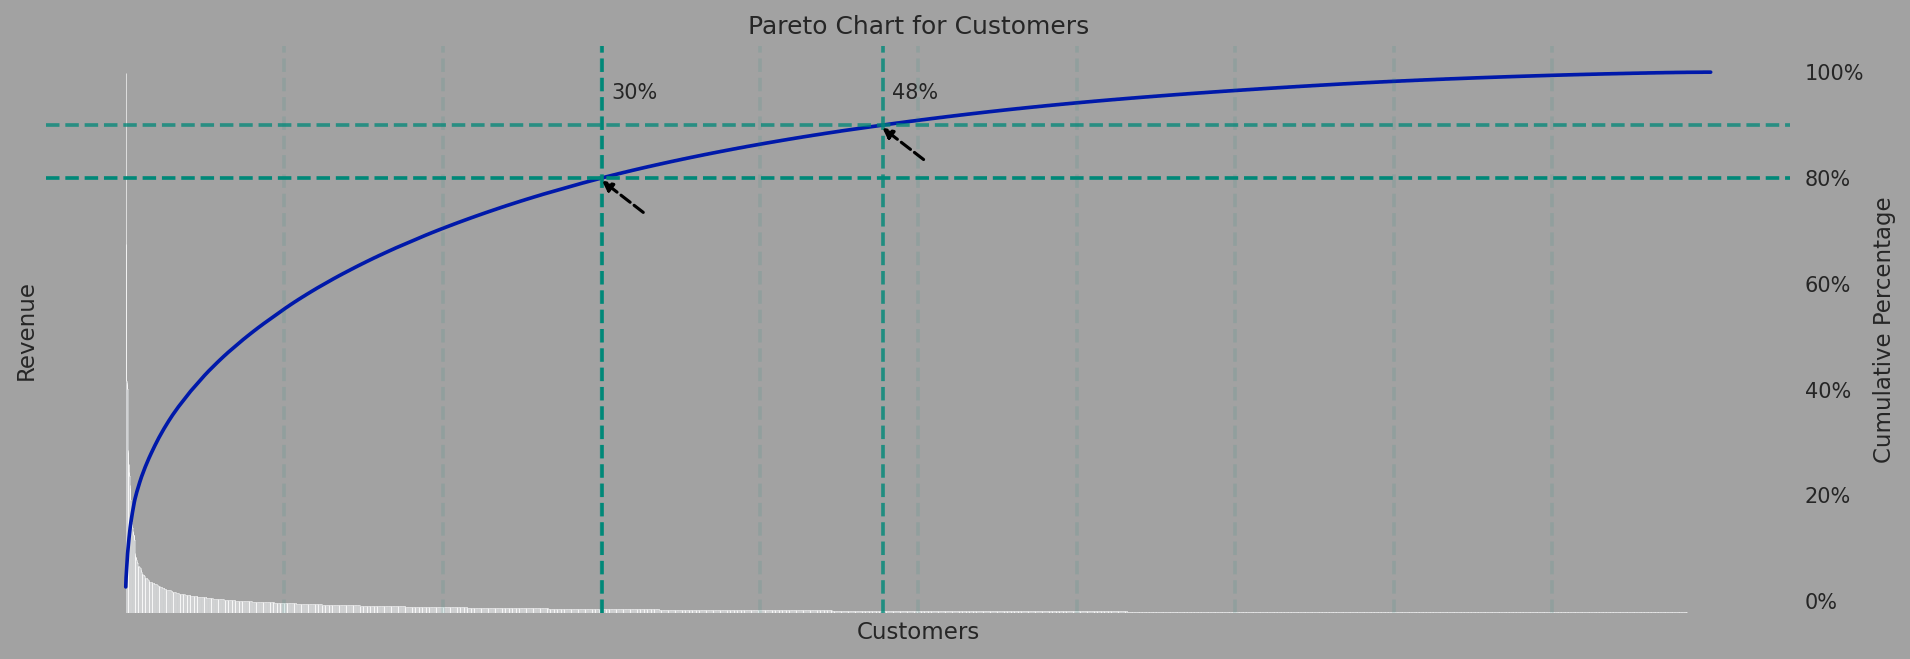

In [58]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

We can also plot it in log scale. It helps us for better visualization.



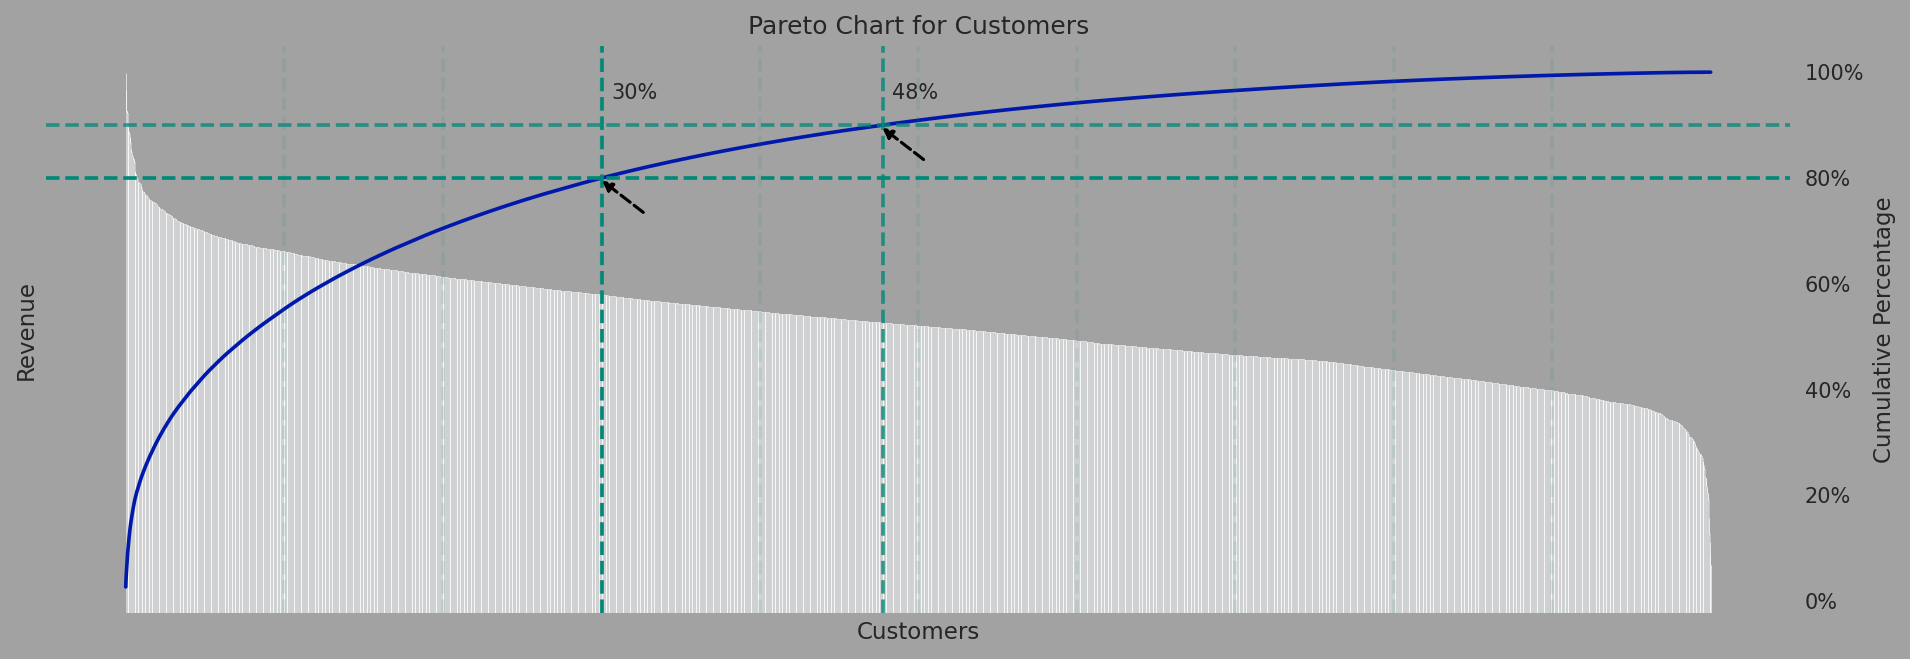

In [59]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

Well, lets interpret these two charts. Actually, we don't need to write a lot of things.

We can see that 80% of company's revenue comes from top 30% of customers.

Also, 90% of company's revenue comes from top 48% of customers

### Pareto Chart for Products

In [60]:
item_price = prepare_pareto_data(df, "StockCode", "TotalPrice")

item_price.head(10)

,TotalPrice,CumulativePercentage
StockCode,,
22423,132100.75,1.84
85123A,68282.78,2.80
47566,61166.83,3.65
85099B,57382.08,4.45
79321,37464.27,4.97
84879,37428.74,5.50
22086,35337.23,5.99
23298,31210.55,6.42
22960,30038.77,6.84


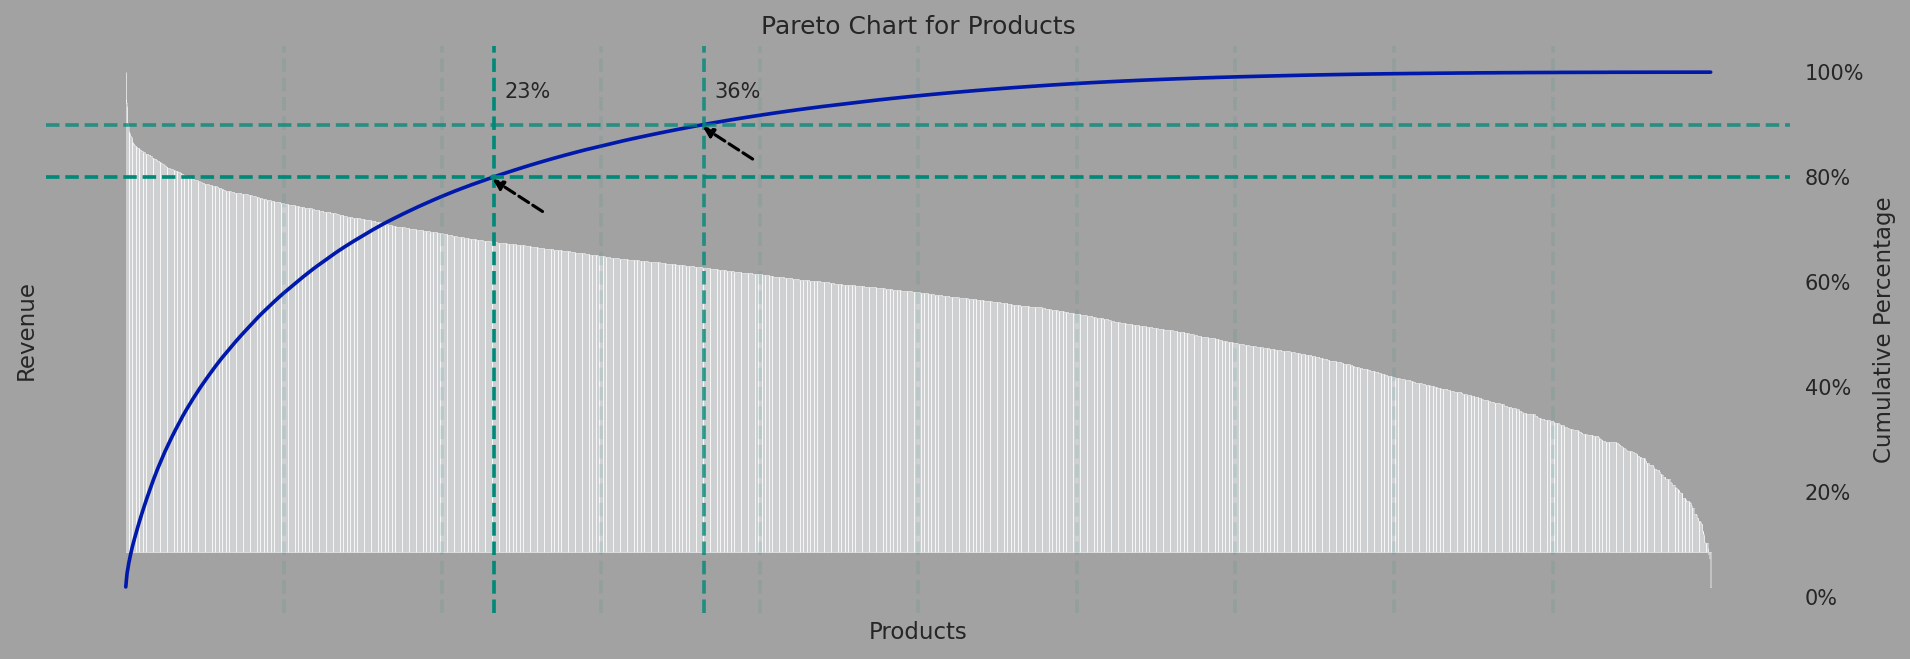

In [61]:
create_pareto_plot(item_price, "StockCode", "TotalPrice", log = True)

We can see that 80% of company's revenue comes from top 23% of products that have most revenue.

Also, 90% of company's revenue comes from 36% of products that have most revenue.

Maybe, if the company reduce by half its variety of items, revenue couldn't decrease significantly.

In [62]:
top_customers = customer_price[customer_price.CumulativePercentage <= 80].index.tolist()

products_for_top_customers = df[df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

products_for_other_customers = df[~df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

# 3. RFM Analysis

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

Recency: How recently a customer has made a purchase

Frequency: How often a customer makes a purchase

Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

Let's perform RFM Analysis on our data.




## Preparing RFM Table

In [63]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [64]:
last_day = df.InvoiceDate.max() + dt.timedelta(days = 1)

In [65]:
rfm_table = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                         "InvoiceNo": "nunique",
                                         "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4060.40
12348.0,75,4,1437.24
12349.0,19,1,1417.60
12350.0,310,1,294.40
12352.0,36,7,1385.74


In [66]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4060.40,5,5,5
12348.0,75,4,1437.24,2,4,4
12349.0,19,1,1417.60,4,1,4
12350.0,310,1,294.40,1,1,2
12352.0,36,7,1385.74,3,5,4


In [67]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15
12348.0,75,4,1437.24,2,4,4,244,10
12349.0,19,1,1417.60,4,1,4,414,9
12350.0,310,1,294.40,1,1,2,112,4
12352.0,36,7,1385.74,3,5,4,354,12


## RFM Segments

Champions: Bought recently, buy often and spend the most

Loyal customers: Buy on a regular basis. Responsive to promotions.

Potential loyalist: Recent customers with average frequency.

Recent customers: Bought most recently, but not often.

Promising: Recent shoppers, but haven’t spent much.

Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.

About to sleep: Below average recency and frequency. Will lose them if not reactivated.

At risk: Some time since they’ve purchased. Need to bring them back!

Can’t lose them: Used to purchase frequently but haven’t returned for a long time.

Hibernating: Last purchase was long back and low number of orders. May be lost.

In [68]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15,Champions
12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
12349.0,19,1,1417.60,4,1,4,414,9,Promising
12350.0,310,1,294.40,1,1,2,112,4,Hibernating
12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers


## Visualizing RFM Grid

In [69]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

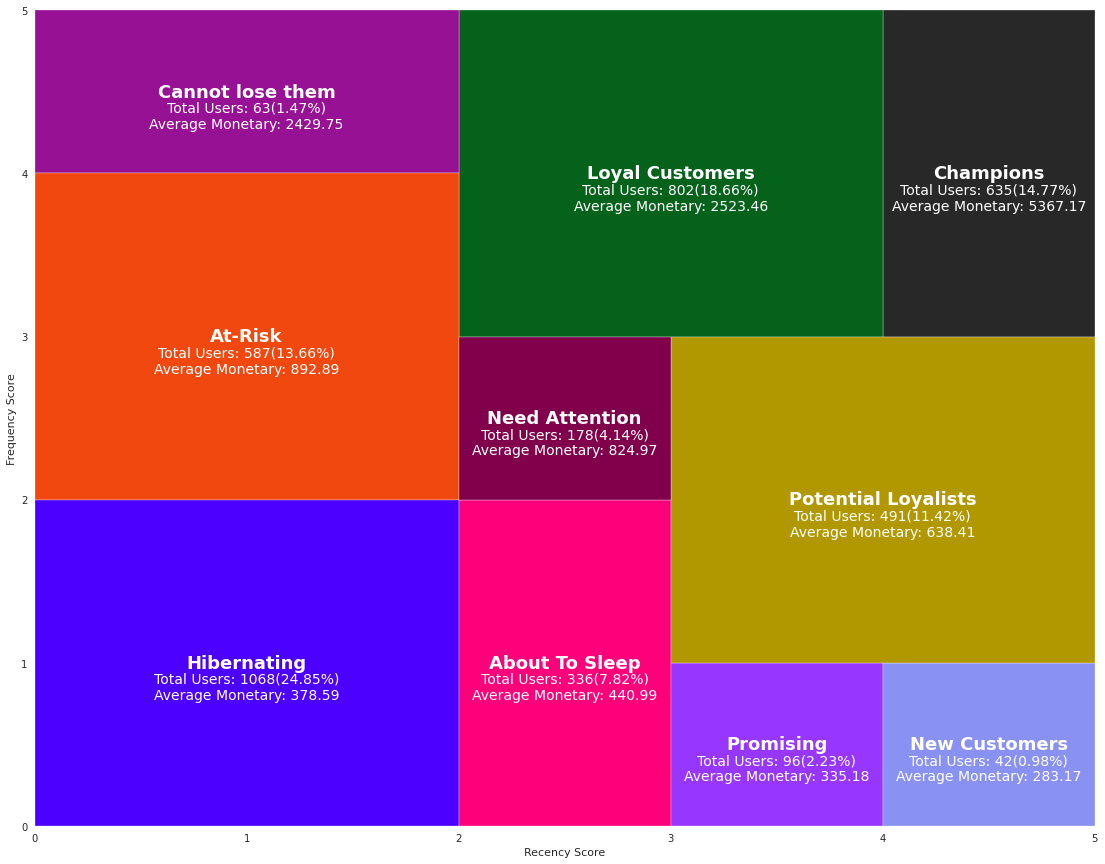

In [70]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

## Visualizing RFM Segments

We can show table of descriptive statistics for RFM segments, but it is not best way. Using data visualization skills and creating great plots as important as finding great results.

In [71]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

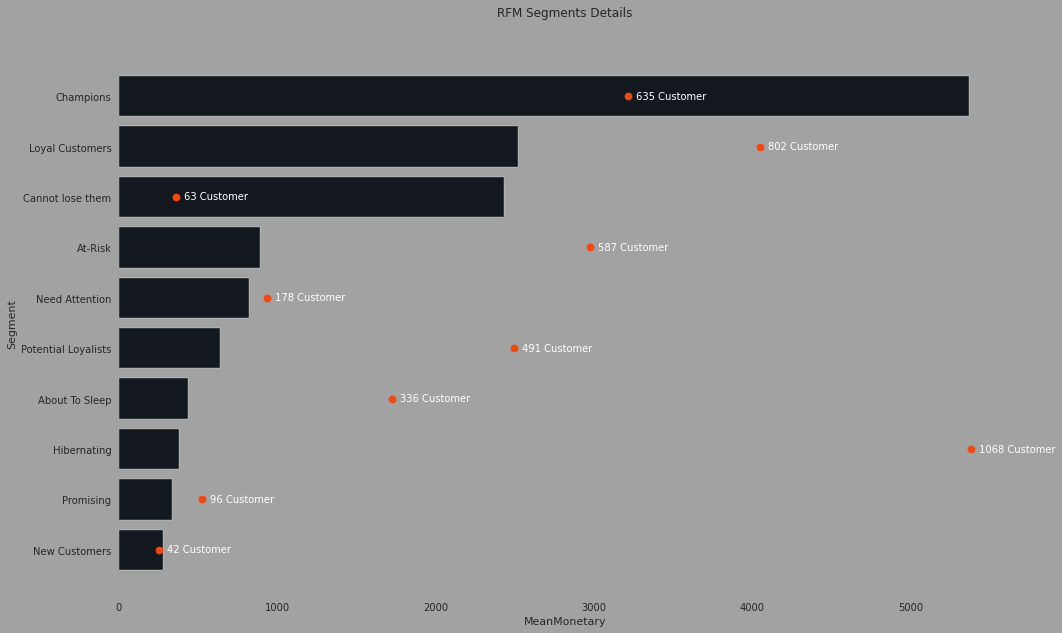

In [72]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [73]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,336.00,587.00,63.00,635.00,1068.00,802.00,178.00,42.00,491.00,96.00
Recency,53.06,152.81,134.65,6.01,216.59,33.30,52.03,7.17,17.18,23.55
Frequency,1.14,2.85,8.30,12.04,1.09,6.39,2.30,1.00,1.99,1.00
Monetary,440.99,892.89,2429.75,5367.17,378.59,2523.46,824.97,283.17,638.41,335.18


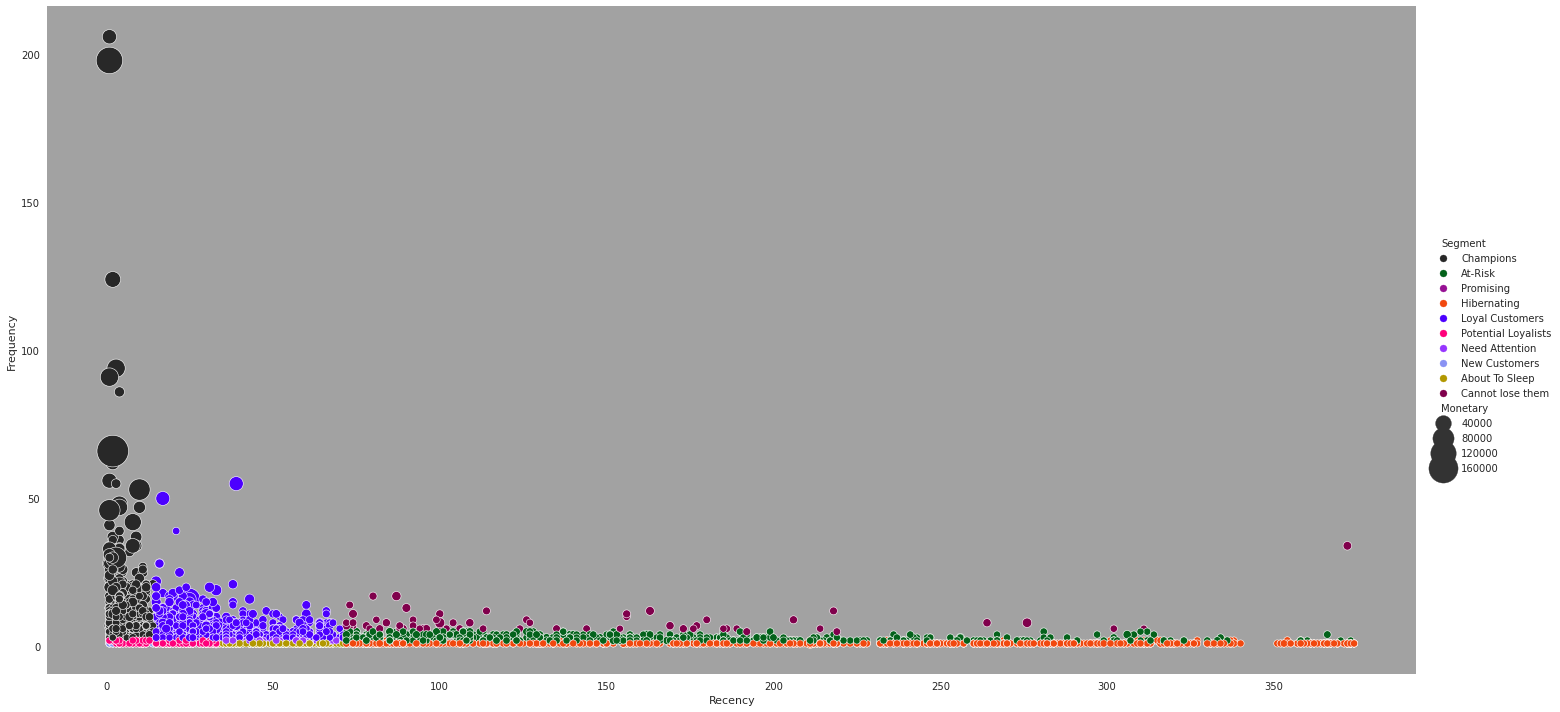

In [74]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = False

sns.relplot(x = "Recency", y = "Frequency", hue = "Segment", size = "Monetary", data = rfm_table2, palette = palette,
            height = 10, aspect = 2, sizes = (50, 1000))

plt.show()

In [75]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

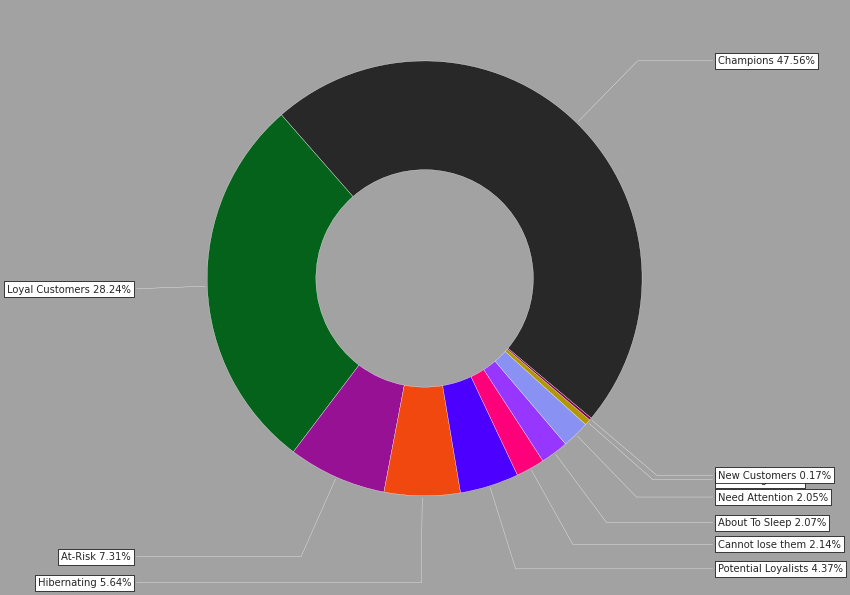

In [76]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

In [77]:
from sklearn.preprocessing import StandardScaler

In [78]:
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]]

for col in ["Recency", "Frequency", "Monetary"]:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    
rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["Recency", "Frequency", "Monetary"],
                     var_name = "RFM", value_name = "Value")

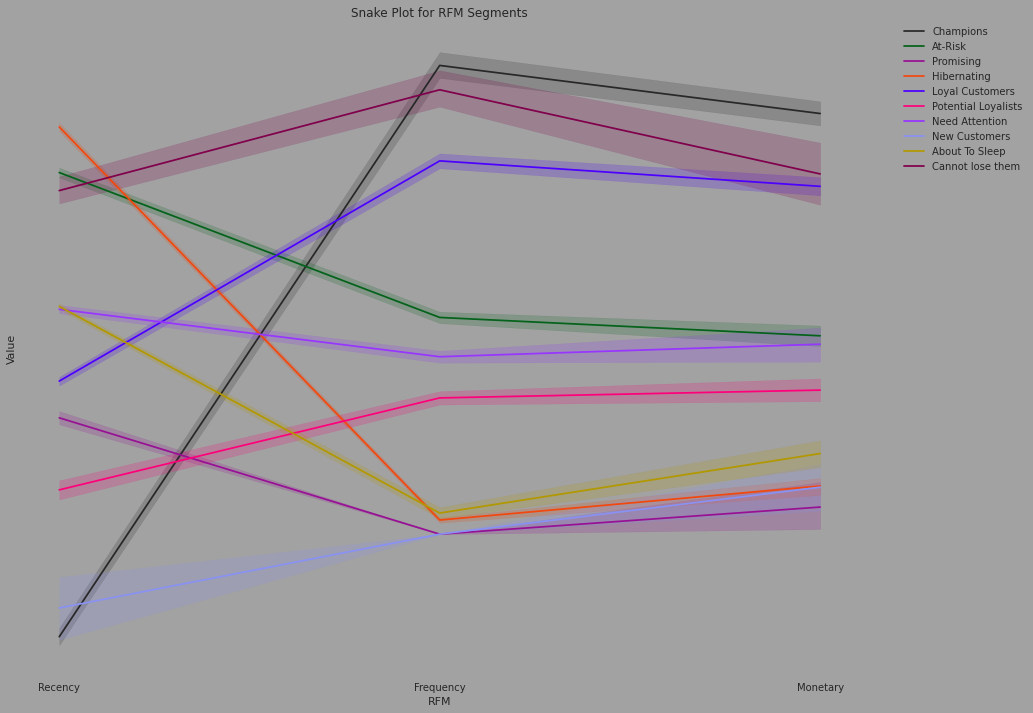

In [79]:
fig, ax = plt.subplots(figsize = (15, 12), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

# 3. Customer Segmentation with using RFM Metrics

In [80]:
# Calculating Monetary attribute
cus_data = df.groupby('CustomerID')[['TotalPrice']].sum() # Total amount spent
cus_data.rename(columns={'TotalPrice':'Monetary'},inplace=True)
cus_data.head()

,Monetary
CustomerID,
12347.0,4060.40
12348.0,1437.24
12349.0,1417.60
12350.0,294.40
12352.0,1385.74


In [81]:
# Calculating frequency attribute
cus_data['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].count()
cus_data.head()

,Monetary,Frequency
CustomerID,,
12347.0,4060.40,181
12348.0,1437.24,27
12349.0,1417.60,71
12350.0,294.40,16
12352.0,1385.74,77


In [82]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [83]:
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDate2,InvoiceMonth,CohortMonth,CohortIndex,diff
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12/1/2010 8:26,2010-12-01,2010-12-01,1,373 days 04:24:00
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01,1,373 days 04:24:00
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12/1/2010 8:26,2010-12-01,2010-12-01,1,373 days 04:24:00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01,1,373 days 04:24:00
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,2010-12-01,2010-12-01,1,373 days 04:24:00


In [84]:
# Adjust today:
import datetime as dt
today = dt.datetime(2012,1,1)
# Recency and Monetary 
data_x = df.groupby('CustomerID').agg({'TotalPrice': lambda x: x.sum(),
                                        'InvoiceDate': lambda x: (today - x.max()).days})
data_x.head()

,TotalPrice,InvoiceDate
CustomerID,,
12347.0,4060.40,24
12348.0,1437.24,97
12349.0,1417.60,40
12350.0,294.40,332
12352.0,1385.74,58


In [85]:
cus_data['Recency'] = df.groupby('CustomerID')['diff'].min().dt.days
cus_data = cus_data.reset_index()
cus_data.head()

,CustomerID,Monetary,Frequency,Recency
0,12347.0,4060.40,181,1
1,12348.0,1437.24,27,74
2,12349.0,1417.60,71,18
3,12350.0,294.40,16,309
4,12352.0,1385.74,77,35


In [86]:
from datetime import datetime
def toDtObject(value):
    return datetime.strptime(value,'%m/%d/%Y %H:%M')

In [87]:
df['InvoiceDate2']=df['InvoiceDate2'].apply(toDtObject)

In [88]:
def getMonth(value):
    return int(value.strftime('%m'))
def getDay(value):
    return int(value.strftime('%d'))
def getYear(value):
    return int(value.strftime('%Y'))
def getHour(value):
    return int(value.strftime('%H'))

In [89]:
df['month']=df['InvoiceDate2'].apply(getMonth)
df['day']=df['InvoiceDate2'].apply(getDay)
df['year']=df['InvoiceDate2'].apply(getYear)
df['hour']=df['InvoiceDate2'].apply(getHour)

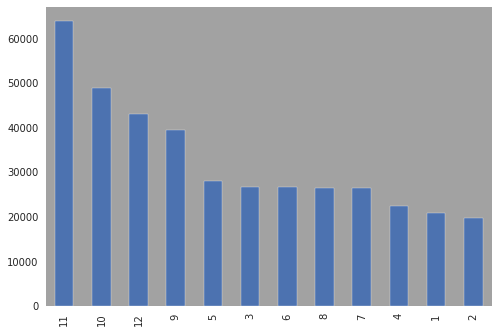

In [90]:
df.month.value_counts().plot(kind='bar')

From the above graph we can conclude that most of sales happended in the last quarter of year

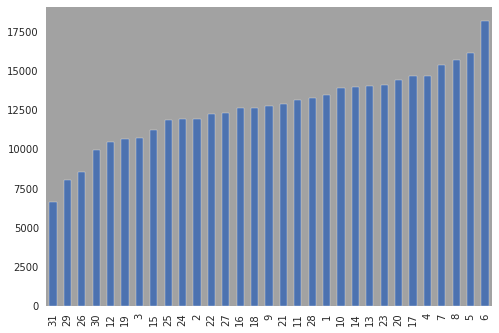

In [91]:
df.day.value_counts(ascending=True).plot(kind='bar')

In [92]:
##### Top 10 items most sales
df.Description.value_counts()[:10]

white hanging heart t-light holder    2003
regency cakestand 3 tier              1708
jumbo bag red retrospot               1562
party bunting                         1384
assorted colour bird ornament         1355
lunch bag red retrospot               1312
set of 3 cake tins pantry design      1155
lunch bag  black skull.               1104
pack of 72 retrospot cake cases       1047
paper chain kit 50's christmas        1011
Name: Description, dtype: int64

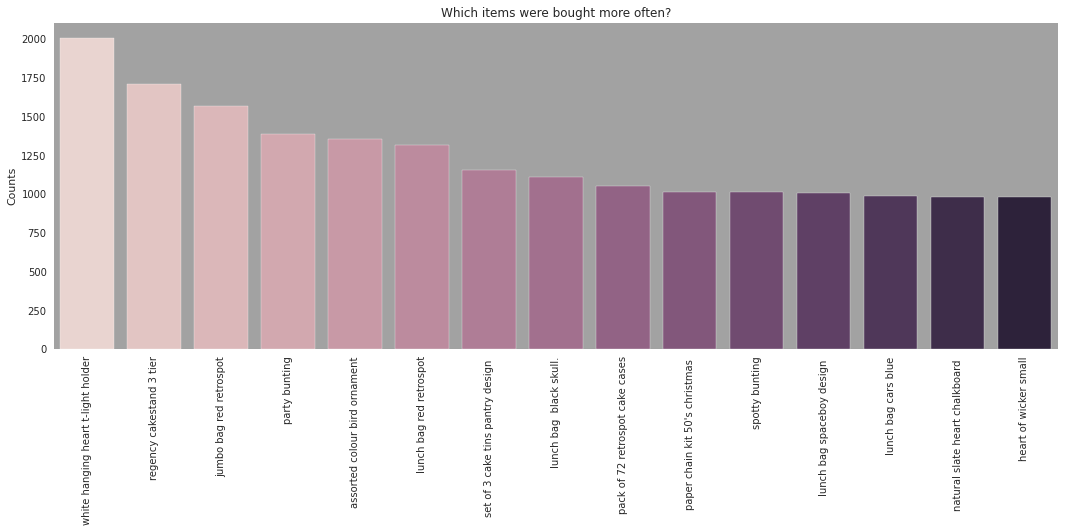

In [93]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [94]:
df[df['month']==11].groupby(['Description']).sum().sort_values(by='TotalPrice',ascending=False)[:5]

,Quantity,UnitPrice,CustomerID,TotalPrice,CohortIndex,month,day,year,hour
Description,,,,,,,,,
rabbit night light,7701,923.67,6821663.0,14807.41,3602,5027,7116,919027,5866
paper chain kit 50's christmas,4379,1041.81,5473927.0,12212.01,2885,3905,5857,713905,4551
regency cakestand 3 tier,940,2127.90,2552913.0,10964.40,1345,1870,2630,341870,2164
hot water bottle keep calm,1742,1312.80,4244709.0,8006.10,2240,2970,4310,542970,3440
paper chain kit vintage christmas,2821,701.06,3646274.0,7736.11,1895,2618,3830,478618,3095


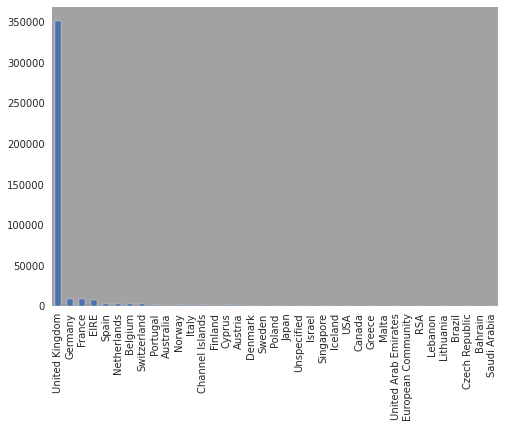

In [95]:
df.Country.value_counts().plot(kind='bar')

* United Kindom has most number of sales and remaining countries sales are very far less than it
* WHITE HANGING HEART T-LIGHT HOLDER and JUMBO BAG RED RETROSPOT product are in top positions
* Most sales happended in November month
* First week of every month has good sales count
* Huge sales are happening around 12 PM everyday
* Most sales happedned in the end of year and maybe it's because of christmas
* In those months christmas gifts related products should have more stock

In [96]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,CustomerID,TotalPrice,CohortIndex,month,day,year,hour
0.050,1.0,0.42,12637.0,1.25,1.0,1.0,2.0,2010.0,9.0
0.950,36.0,8.50,17908.0,59.80,12.0,12.0,29.0,2011.0,17.0
0.980,64.0,10.95,18121.0,102.00,12.0,12.0,30.0,2011.0,17.0
0.990,96.0,12.75,18212.0,165.00,13.0,12.0,31.0,2011.0,19.0
0.999,144.0,16.95,18283.0,367.20,13.0,12.0,31.0,2011.0,20.0


(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.]), <a list of 8 Text major ticklabel objects>)

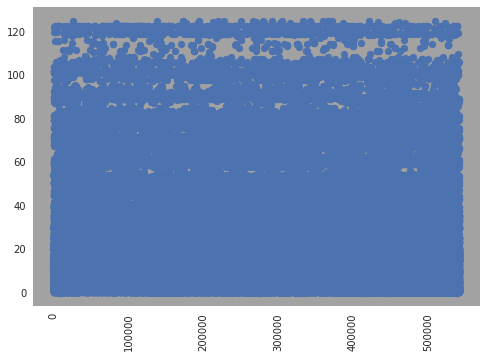

In [97]:
df_quantile = df[df['TotalPrice'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['TotalPrice'])
plt.xticks(rotation=90)

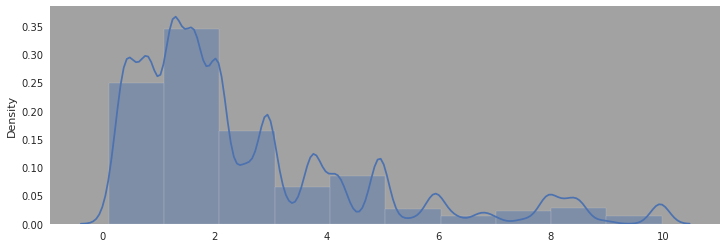

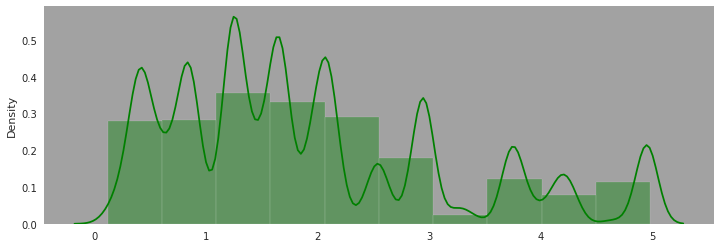

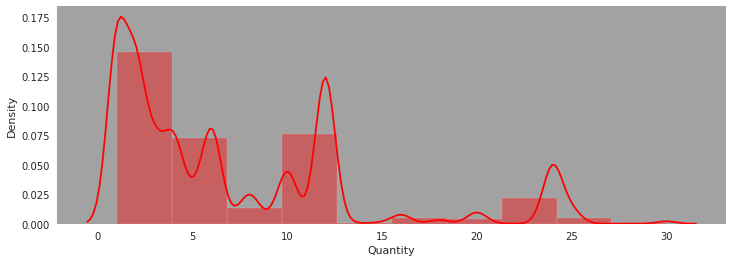

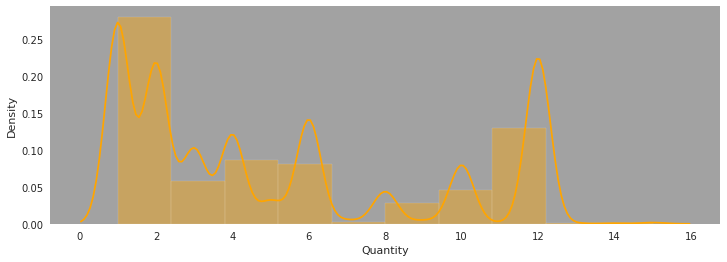

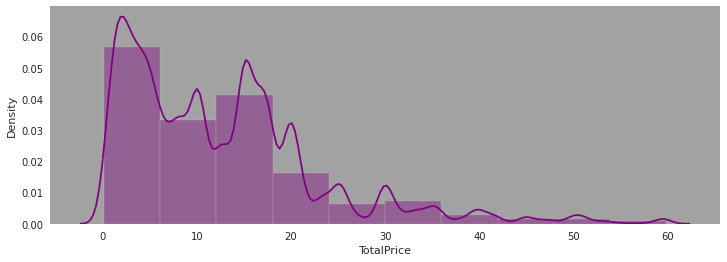

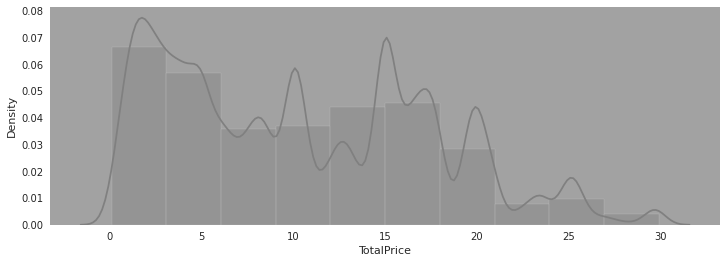

In [98]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['TotalPrice'] < 60]['TotalPrice'], kde=True, bins=10, color='purple')
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['TotalPrice'] < 30]['TotalPrice'], kde=True, bins=10, color='grey')

- From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets?
- From these histograms we can understand that majority of 
sales per order were in range 1-15 pounds each

Treating Outliers

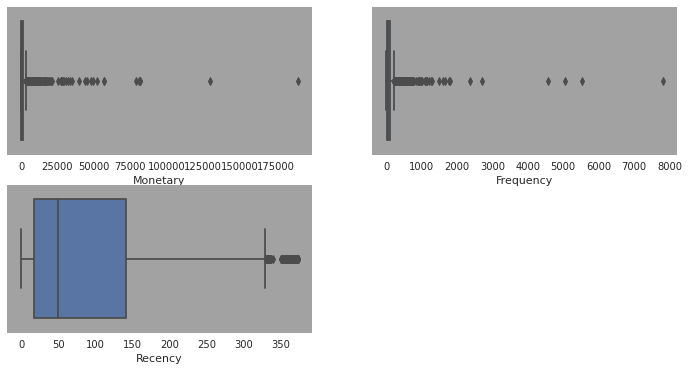

In [99]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [100]:
h_cap = 0.95
h_cap_val = cus_data['Monetary'].quantile(h_cap)
cus_data['Monetary'][cus_data['Monetary'] > h_cap_val] = h_cap_val
l_cap = 0.05
l_cap_val = cus_data['Monetary'].quantile(l_cap)
cus_data['Monetary'][cus_data['Monetary'] < l_cap_val] = l_cap_val
cap = 0.95
cap_val = cus_data['Frequency'].quantile(cap)
cus_data['Frequency'][cus_data['Frequency'] > cap_val] = cap_val

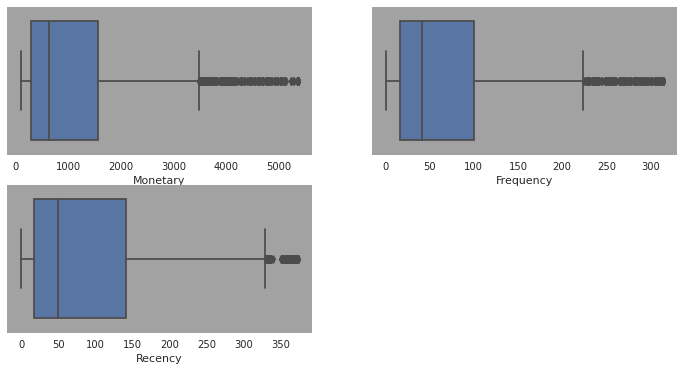

In [101]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )

In [103]:
X = cus_data.drop('CustomerID',axis=1)
X_scaled = pd.DataFrame(preprocessor.fit_transform(X),columns=['PC_1','PC_2'])

In [104]:
X_scaled.head()

,PC_1,PC_2
0,0.662820,0.071900
1,-0.049485,-0.076881
2,0.105706,-0.167020
3,-0.497690,0.398526
4,0.093001,-0.122535


## Hopkins Test 

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [105]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [106]:
for i in range(5):
  print('Hopkins statistic value is:',round(hopkins(X_scaled),3))

Hopkins statistic value is: 0.964
Hopkins statistic value is: 0.964
Hopkins statistic value is: 0.961
Hopkins statistic value is: 0.963
Hopkins statistic value is: 0.963


*Since* the Hopkins test value hovers around 0.967, therefore given data have high clustering tendency.

## Finding Optimal value of K (Clusters)

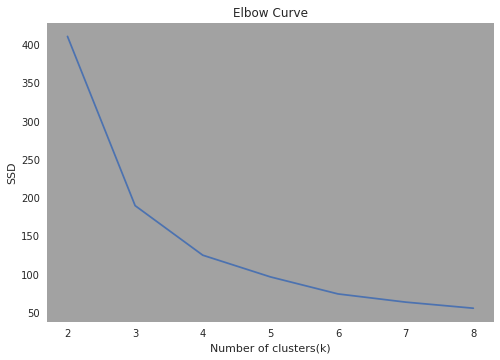

In [107]:
# elbow-curve/SSD
# k means for scaled dataset
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [108]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.54
For n_clusters=3, the silhouette score is 0.55
For n_clusters=4, the silhouette score is 0.52
For n_clusters=5, the silhouette score is 0.48
For n_clusters=6, the silhouette score is 0.46
For n_clusters=7, the silhouette score is 0.43
For n_clusters=8, the silhouette score is 0.41


Using silhouette analysis k=3 seems to be the optimal number of clusters.

In [109]:
# final model with k=3
kmeans_new = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans_new.fit(X_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=1)

In [110]:
# Adding cluster labels to master dataframe
X_scaled['cluster_id'] = kmeans_new.labels_
X['cluster_id'] = kmeans_new.labels_
X.head(4)

,Monetary,Frequency,Recency,cluster_id
0,4060.40,181.0,1,1
1,1437.24,27.0,74,0
2,1417.60,71.0,18,0
3,294.40,16.0,309,2


In [111]:
X2 = X.drop(columns=['cluster_id'])
X2.head(5)

,Monetary,Frequency,Recency
0,4060.40,181.0,1
1,1437.24,27.0,74
2,1417.60,71.0,18
3,294.40,16.0,309
4,1385.74,77.0,35


### k means for raw dataset

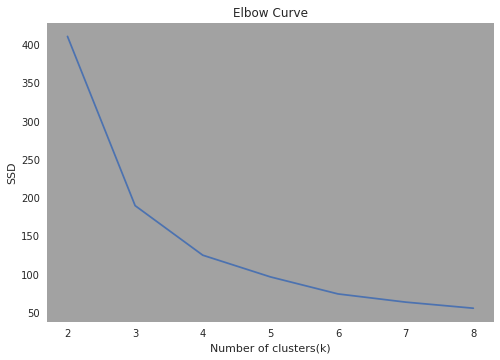

In [112]:
# k means for raw dataset
ssd2 = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X2)
    ssd2.append(kmeans.inertia_)

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [113]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X2)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X2, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.75
For n_clusters=3, the silhouette score is 0.67
For n_clusters=4, the silhouette score is 0.62
For n_clusters=5, the silhouette score is 0.57
For n_clusters=6, the silhouette score is 0.54
For n_clusters=7, the silhouette score is 0.51
For n_clusters=8, the silhouette score is 0.5


In [114]:
# final model for raw dataset with k=3
kmeans_rfm = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans_rfm.fit(X2)

KMeans(max_iter=50, n_clusters=3, random_state=1)

In [115]:
X2['cluster_id'] = kmeans_rfm.labels_

In [116]:
kmeans_rfm.predict([[200,80,40]])

array([0], dtype=int32)

## Trying Agglomotative and DBSCAN clustering algorithms

In [117]:
aggX = X.drop(columns=['cluster_id'])
aggX_sc = X_scaled.drop(columns=['cluster_id'])

dbX = X.drop(columns=['cluster_id'])
dbX_sc = X_scaled.drop(columns=['cluster_id'])

In [118]:
aggX_sc.head(5)

,PC_1,PC_2
0,0.662820,0.071900
1,-0.049485,-0.076881
2,0.105706,-0.167020
3,-0.497690,0.398526
4,0.093001,-0.122535


In [119]:
agglom = AgglomerativeClustering(n_clusters=3, linkage='average').fit(aggX)
aggX['AggloPred'] = agglom.labels_


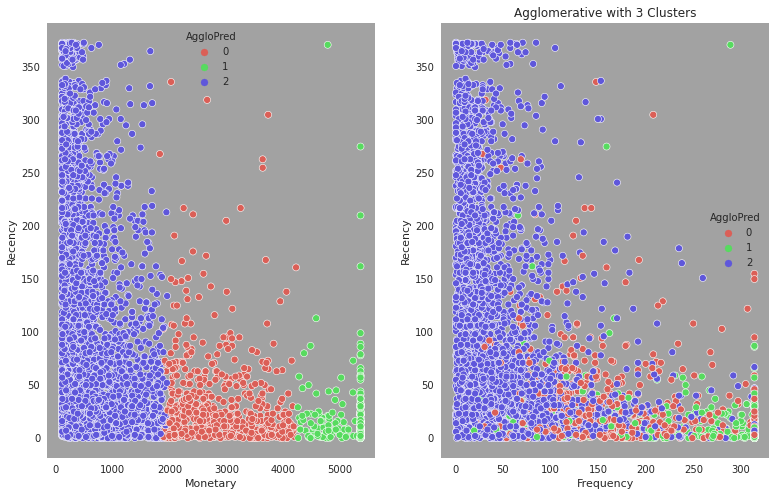

In [120]:
fig = plt.figure(figsize=[20,8])

plt.subplot(1,3,1)
sns.scatterplot(aggX['Monetary'], aggX['Recency'], hue=aggX['AggloPred'], 
                palette=sns.color_palette('hls', 3))
plt.subplot(1,3,2)
sns.scatterplot(aggX['Frequency'], aggX['Recency'], hue=aggX['AggloPred'], 
                palette=sns.color_palette('hls', 3))
plt.title('Agglomerative with 3 Clusters')
plt.show()

## Customer distribution

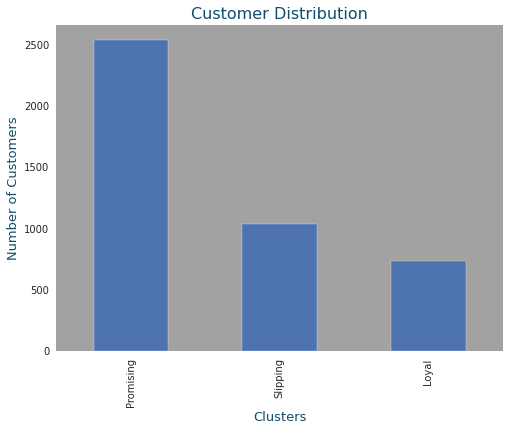

In [121]:
# Number of customers per cluster

font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = X_scaled['cluster_id'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Promising','Slipping','Loyal'])
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()

In [122]:
fig = plt.figure(figsize=[15,7])
fig = px.scatter_3d(X, x = 'Monetary', y='Frequency', z='Recency',
              color='cluster_id', opacity = 0.8,size_max=30)
fig.show()

<Figure size 1080x504 with 0 Axes>

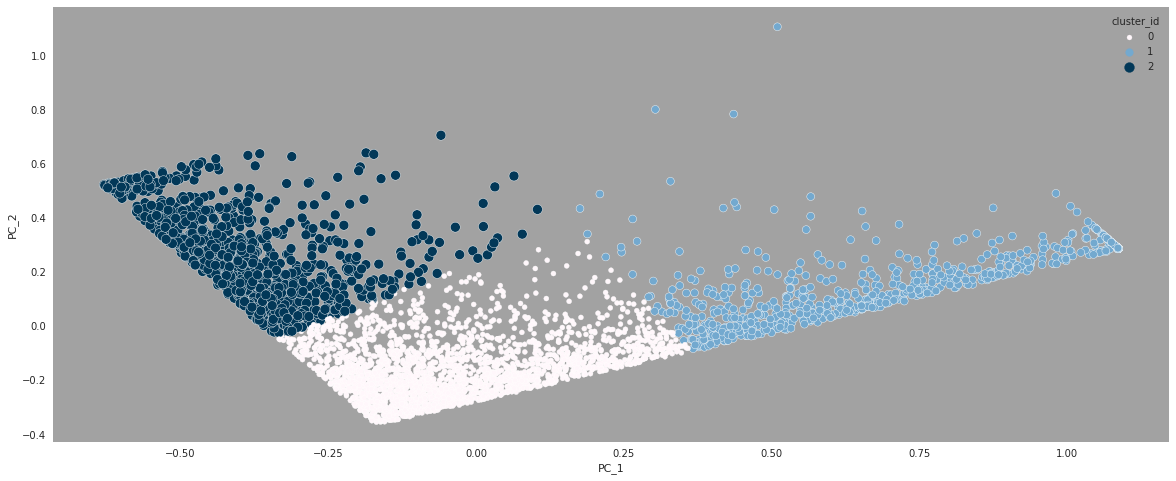

In [123]:
# Vusializing clusters using Principle Components
fig = plt.figure(figsize=[20,8])
sns.scatterplot(data=X_scaled,x="PC_1",y="PC_2",hue="cluster_id",size="cluster_id",palette="PuBu")
plt.show()

## Inference:

* Cluster 0 contains the customers who generate the least revenue and are not frequent, most likely because these were one-time customers. Hence they can be labeled as Slipping.
* Cluster 1 seems to have the most loyal customers, as they bring the most revenue and are often the most frequent customers.
* Cluster 2 customers seem promising as it consists of frequent buyers, however revenue generation is not as high as Loyal customers

# 5. Recommendations


* After segmenting customers into loyal, slipping, and promising it empowers businesses to run personalized, high-performing campaigns and preserves profit margin. Below are a few recommendations or targeted strategies for each customer segment:

* Loyal - Loyalty programs are effective for these repeat visitors. Advocacy programs and reviews are also common X1X strategies. Lastly, consider rewarding these customers with Free Shipping or other like benefits.

* Promising - Focus on increasing monetization through product recommendations based on past purchases and incentives tied to spending thresholds.

* Slipping - Customers leave for a variety of reasons. Depending on your situation price deals, new product launches, or other retention strategies.